# EmotiCode: Multi-Script Emotion Classification Challenge

This notebook implements a solution for classifying emotions in low-resource languages (Santali, Kashmiri, and Manipuri) using Google's Gemma-3-1B-IT model.

## Task Overview
- Develop an emotion classification model for three linguistically diverse languages
- Use Gemma-3-1B-IT as the base model
- Classify text into 6 emotion classes: fear, happy, surprise, sad, anger, disgust
- Evaluation metric: Macro F1-Score

## 1. Setup and Installation

Let's start by installing the necessary libraries:

In [1]:
!pip install -q transformers datasets evaluate accelerate unsloth bitsandbytes pandas scikit-learn tqdm wandb matplotlib seaborn

### Kaggle Authentication (if running in Kaggle)

If you're running this in a Kaggle notebook, uncomment and run the following cell:

In [13]:
from dotenv import load_dotenv
from huggingface_hub import login
import os

load_dotenv()  # Automatically loads .env file from current directory

login(token=os.getenv("HUGGINGFACE_HUB_TOKEN"))

## 2. Import Required Libraries

In [14]:
import os
import numpy as np
import pandas as pd
import torch
import random
import evaluate
from tqdm import tqdm
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    TrainingArguments,
    Trainer,
    EvalPrediction,
    get_scheduler
)

# Import Unsloth for faster fine-tuning
from unsloth import FastLanguageModel

## 3. Set Random Seeds for Reproducibility

In [15]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)

## 4. Load and Explore Data

In [16]:
# Load datasets
train_data = pd.read_csv('competition_train.csv')
validation_data = pd.read_csv('competition_val.csv')
test_data = pd.read_csv('competition_test.csv')

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Check the first few samples
train_data.head()

Train data shape: (7176, 4)
Validation data shape: (2392, 4)
Test data shape: (2392, 3)


,id,Sentence,language,emotion
0,1801,رُک، بہٕ چھس صرف یہ یقینی بناونٕچ کوٗشش کران ز...,Kashmiri,disgust
1,7895,بہٕ چھس مایوس گژھان ییٚلہ بہٕ بٹوار دۄہ شامس ا...,Kashmiri,anger
2,3369,ꯑꯩꯒꯤ ꯑꯉꯥꯡ ꯌꯣꯛꯄꯗ ꯆꯥꯗꯤꯡꯁꯤ ꯀꯌꯥ ꯌꯥꯝꯅ ꯍꯦꯟꯒꯠꯂꯛꯂꯤꯕꯒꯦ ...,Manipuri,sad
3,5191,بہٕ چھس بیٚنٛکس مٗقابلہٕ جٲتی سودٕکہِ شرح پیش...,Kashmiri,anger
4,7934,کوچ سٕنٛز سپورٹس مینشِپٕچ کٔمی چھےٚ واریاہ مای...,Kashmiri,disgust


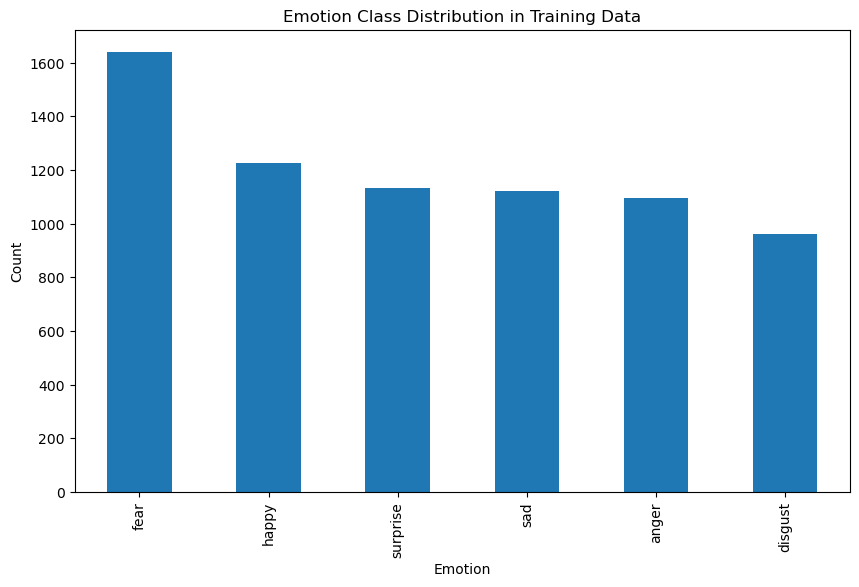

Emotion class distribution in training data:
emotion
fear        1640
happy       1225
surprise    1132
sad         1122
anger       1097
disgust      960
Name: count, dtype: int64


In [17]:
# Check class distribution in training data
plt.figure(figsize=(10, 6))
train_data['emotion'].value_counts().plot(kind='bar')
plt.title('Emotion Class Distribution in Training Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

# Print counts
print("Emotion class distribution in training data:")
print(train_data['emotion'].value_counts())

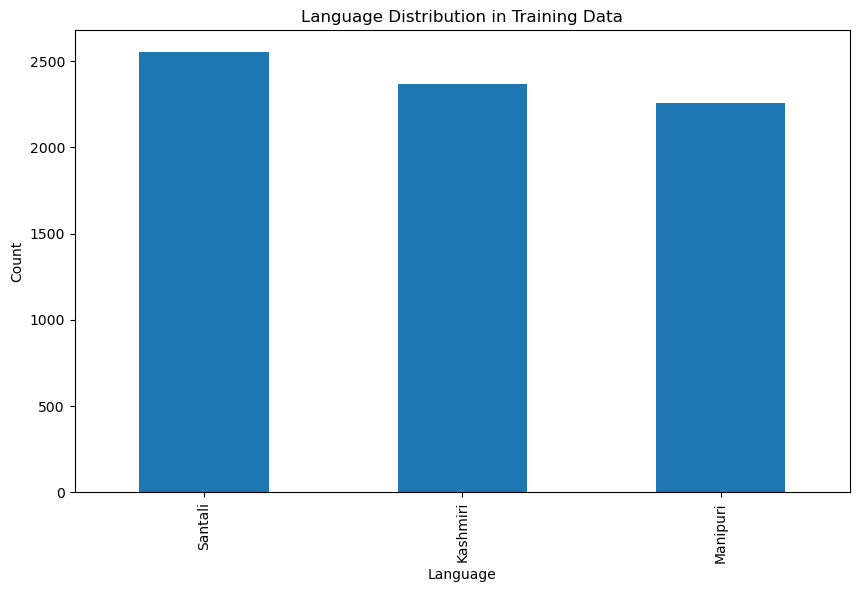

Language distribution in training data:
language
Santali     2551
Kashmiri    2367
Manipuri    2258
Name: count, dtype: int64


In [18]:
# Check language distribution in training data
plt.figure(figsize=(10, 6))
train_data['language'].value_counts().plot(kind='bar')
plt.title('Language Distribution in Training Data')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

# Print counts
print("Language distribution in training data:")
print(train_data['language'].value_counts())

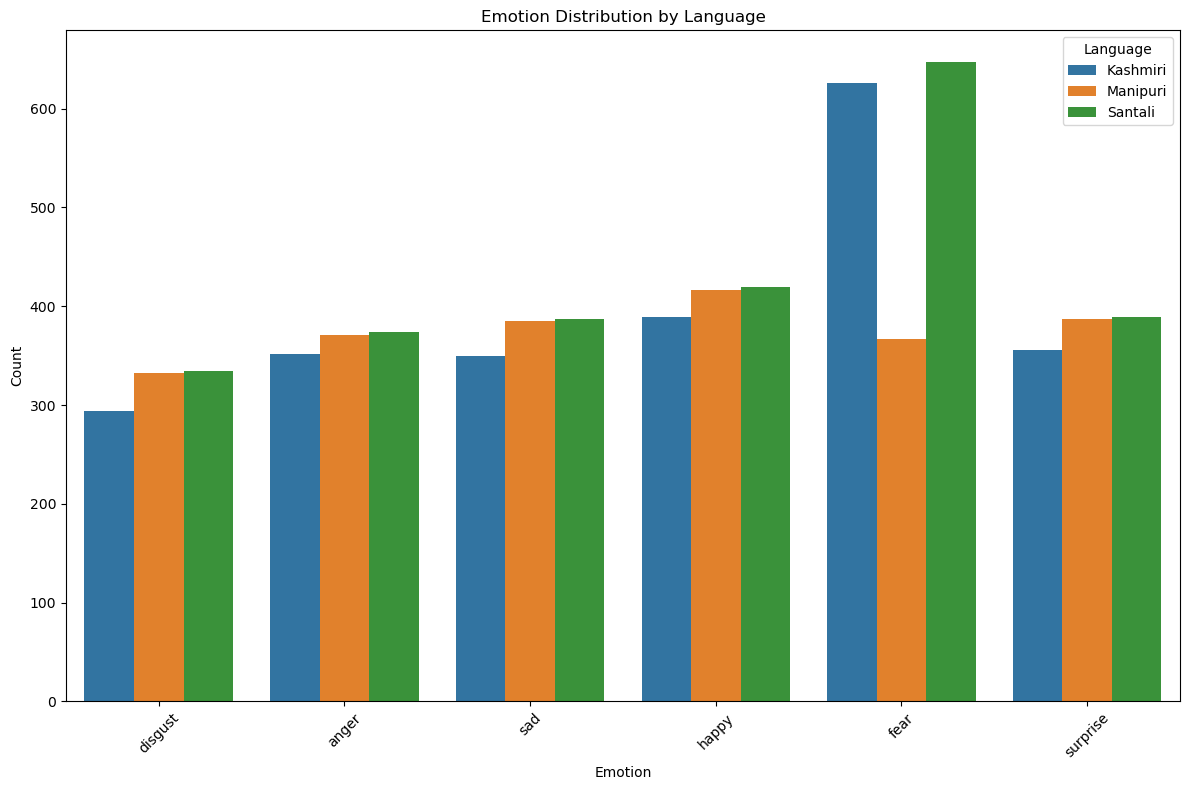

In [19]:
# Check distribution of emotions across languages
plt.figure(figsize=(12, 8))
sns.countplot(x='emotion', hue='language', data=train_data)
plt.title('Emotion Distribution by Language')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Language')
plt.tight_layout()
plt.show()

## 5. Data Preprocessing

In [20]:
# Create label mapping
label_mapping = {}
unique_emotions = train_data['emotion'].unique()
for i, emotion in enumerate(sorted(unique_emotions)):
    label_mapping[emotion] = i

print("Label mapping:")
print(label_mapping)

# Convert to HuggingFace Datasets
def prepare_dataset(df, is_test=False):
    dataset_dict = {'id': df['id'].tolist(), 'text': df['Sentence'].tolist(), 'language': df['language'].tolist()}
    if not is_test:
        dataset_dict['label'] = [label_mapping[emotion] for emotion in df['emotion'].tolist()]
    return Dataset.from_dict(dataset_dict)

train_dataset = prepare_dataset(train_data)
val_dataset = prepare_dataset(validation_data)
test_dataset = prepare_dataset(test_data, is_test=True)

# Combine into a dataset dictionary
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Print info about the datasets
print("\nDataset info:")
for split, dataset in dataset_dict.items():
    print(f"{split}: {dataset}")

Label mapping:
{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5}

Dataset info:
train: Dataset({
    features: ['id', 'text', 'language', 'label'],
    num_rows: 7176
})
validation: Dataset({
    features: ['id', 'text', 'language', 'label'],
    num_rows: 2392
})
test: Dataset({
    features: ['id', 'text', 'language'],
    num_rows: 2392
})


### Create Prompt Templates for Different Languages

We'll create language-specific prompt templates to help the model understand the task.

In [39]:
def create_prompt(example, add_instruction=True):
    language = example['language']
    text = example['Sentence']
    
    # Create language-specific prompts
    if language == 'Santali':
        lang_desc = "Santali language text in OI Chiki script"
    elif language == 'Kashmiri':
        lang_desc = "Kashmiri language text in Arabic script"
    else:  # Manipuri
        lang_desc = "Manipuri language text in Meitei Mayek script"
    
    # First format
    if add_instruction:
        prompt = f"""Classify the emotion expressed in the following {lang_desc}. 
Choose from: fear, happy, surprise, sad, anger, disgust.

Text: {text}

Emotion: """
    else: # Second format
        prompt = f"""The following is {lang_desc}: {text}

The emotion expressed in this text is: """
    
    return prompt

# Create a few examples to see the prompts
example = train_data.iloc[0].to_dict()
print(create_prompt(example))
print("\nAlternative prompt format:")
print(create_prompt(example, add_instruction=False))

Classify the emotion expressed in the following Kashmiri language text in Arabic script. 
Choose from: fear, happy, surprise, sad, anger, disgust.

Text: رُک، بہٕ چھس صرف یہ یقینی بناونٕچ کوٗشش کران ز مےٚ چھ فراہم کرنہٕ آمتیٚن خدماتن خٲطرٕ معقول قۭمت میلان۔

Emotion: 

Alternative prompt format:
The following is Kashmiri language text in Arabic script: رُک، بہٕ چھس صرف یہ یقینی بناونٕچ کوٗشش کران ز مےٚ چھ فراہم کرنہٕ آمتیٚن خدماتن خٲطرٕ معقول قۭمت میلان۔

The emotion expressed in this text is: 


## 6. Load Model and Tokenizer

We'll use Google's Gemma-3-1B-IT model for our task.

In [40]:
# Check if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [41]:
# Load tokenizer
model_id = "google/gemma-3-1b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer loaded: {tokenizer.__class__.__name__}")

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Tokenizer loaded: GemmaTokenizerFast


In [42]:
# Let's test the tokenizer on our data to see how it handles the different scripts
samples = [
    train_data[train_data['language'] == 'Santali'].iloc[0]['Sentence'],
    train_data[train_data['language'] == 'Kashmiri'].iloc[0]['Sentence'],
    train_data[train_data['language'] == 'Manipuri'].iloc[0]['Sentence']
]

for sample in samples:
    tokens = tokenizer.tokenize(sample)
    print(f"Sample: {sample}")
    print(f"Number of tokens: {len(tokens)}")
    print("First 10 tokens:", tokens[:10])
    print("\n")

Sample: ᱟᱨᱦᱚᱸ ᱱᱟᱯᱟᱭ ᱥᱮ ᱵᱟᱝ, ᱤᱧ ᱢᱤᱫᱴᱟᱝ ᱥᱮᱨᱢᱟᱠᱤᱭᱟᱹ ᱤᱱᱴᱟᱨᱱᱮᱴ ᱥᱟᱵᱥᱠᱨᱤᱯᱥᱚᱱ ᱞᱟᱹᱜᱤᱫ ᱥᱮᱱ ᱟᱠᱟᱱᱟ, ᱱᱚᱣᱟ ᱩᱭᱦᱟᱹᱨ ᱵᱤᱨᱩᱫᱷᱨᱮ ᱡᱮ, ᱱᱚᱶᱟ ᱫᱚ ᱤᱧᱟᱹᱜ ᱚᱯᱷᱤᱥ ᱠᱚᱞ ᱫᱚ ᱵᱟᱝ ᱦᱟᱹᱱᱼᱟ ᱾
Number of tokens: 144
First 10 tokens: ['ᱟ', 'ᱨ', 'ᱦ', 'ᱚ', 'ᱸ', '▁', 'ᱱ', 'ᱟ', 'ᱯ', 'ᱟ']


Sample: رُک، بہٕ چھس صرف یہ یقینی بناونٕچ کوٗشش کران ز مےٚ چھ فراہم کرنہٕ آمتیٚن خدماتن خٲطرٕ معقول قۭمت میلان۔
Number of tokens: 51
First 10 tokens: ['ر', 'ُ', 'ک', '،', '▁بہ', 'ٕ', '▁چھ', 'س', '▁صرف', '▁یہ']


Sample: ꯑꯩꯒꯤ ꯑꯉꯥꯡ ꯌꯣꯛꯄꯗ ꯆꯥꯗꯤꯡꯁꯤ ꯀꯌꯥ ꯌꯥꯝꯅ ꯍꯦꯟꯒꯠꯂꯛꯂꯤꯕꯒꯦ ꯍꯥꯏꯕꯗꯨ ꯎꯕꯗ ꯇꯁꯦꯡꯅ ꯄꯨꯛꯅꯤꯡ ꯁꯣꯟꯊꯩ꯫
Number of tokens: 150
First 10 tokens: ['ꯑ', '<0xEA>', '<0xAF>', '<0xA9>', '<0xEA>', '<0xAF>', '<0x92>', 'ꯤ', '▁', 'ꯑ']




## 7. Tokenize Datasets

In [44]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'language', 'label'],
        num_rows: 7176
    })
    validation: Dataset({
        features: ['id', 'text', 'language', 'label'],
        num_rows: 2392
    })
    test: Dataset({
        features: ['id', 'text', 'language'],
        num_rows: 2392
    })
})

In [45]:
# Define max sequence length
max_length = 256

def tokenize_function(examples):
    prompts = [create_prompt({'Sentence': text, 'language': lang}) for text, lang in zip(examples['text'], examples['language'])]
    
    tokenized = tokenizer(
        prompts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    
    return tokenized

# Tokenize datasets
tokenized_datasets = dataset_dict.map(
    tokenize_function,
    batched=True,
    remove_columns=['id', 'text', 'language'] if 'label' in dataset_dict['train'].features else ['id', 'text', 'language']
)

print("Tokenized datasets:")
for split, dataset in tokenized_datasets.items():
    print(f"{split}: {dataset}")

Map:   0%|          | 0/7176 [00:00<?, ? examples/s]

Map:   0%|          | 0/2392 [00:00<?, ? examples/s]

Map:   0%|          | 0/2392 [00:00<?, ? examples/s]

Tokenized datasets:
train: Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 7176
})
validation: Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 2392
})
test: Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 2392
})


## 8. Set Up Training Arguments for Parameter-Efficient Fine-Tuning

We'll use LoRA (Low-Rank Adaptation) for efficient fine-tuning.

In [70]:
# Setup model with Unsloth for faster fine-tuning with LoRA
model_id = "unsloth/gemma-3-1b-it"

# Number of labels
num_labels = len(label_mapping)

# Model and LoRA configuration
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_id,
    max_seq_length=max_length,
    dtype=torch.float16,
    load_in_4bit=True,
)

# Add classification head
model = FastLanguageModel.get_peft_model(
    model,
    r=16,  # LoRA attention dimension
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    use_gradient_checkpointing=True,
    random_state=42,
    use_rslora=False,  # More powerful than regular LoRA
)

ImportError: cannot import name 'StaticCache' from 'transformers.models.gemma3.modeling_gemma3' (/home/sachin/miniconda3/envs/lmlf/lib/python3.10/site-packages/transformers/models/gemma3/modeling_gemma3.py)

In [69]:
from transformers.models.gemma3.modeling_gemma3 import StaticCache, HybridCach


ImportError: cannot import name 'StaticCache' from 'transformers.models.gemma3.modeling_gemma3' (/home/sachin/miniconda3/envs/lmlf/lib/python3.10/site-packages/transformers/models/gemma3/modeling_gemma3.py)

In [ ]:
# Define a custom trainer for sequence classification
class EmotionClassificationTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.label_names = list(label_mapping.keys())
    
    def compute_loss(self, model, inputs, return_outputs=False):
        # Get the input_ids and attention_mask
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        labels = inputs["labels"]
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Compute loss
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, len(label_mapping)), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss
    
    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        # Move inputs to appropriate device
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Forward pass
        with torch.no_grad():
            outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
            logits = outputs.logits
            
        # Compute loss
        loss = None
        if "labels" in inputs:
            labels = inputs["labels"]
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, len(label_mapping)), labels.view(-1))
        
        if prediction_loss_only:
            return (loss, None, None)
        
        return (loss, logits, inputs["labels"] if "labels" in inputs else None)

## 9. Define Evaluation Metric

We'll use Macro F1-Score for evaluation, which is the primary metric for this competition.

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate macro F1 score
    f1_macro = f1_score(labels, predictions, average='macro')
    
    # Calculate individual F1 scores for each class
    f1_per_class = f1_score(labels, predictions, average=None)
    f1_dict = {emotion: score for emotion, score in zip(label_mapping.keys(), f1_per_class)}
    
    # Create detailed classification report
    report = classification_report(labels, predictions, target_names=list(label_mapping.keys()), output_dict=True)
    
    metrics = {
        'f1_macro': f1_macro,
        **{f'f1_{emotion}': score for emotion, score in f1_dict.items()},
        'accuracy': (predictions == labels).mean()
    }
    
    return metrics

## 10. Fine-tune the Model

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="emotion_classification_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    push_to_hub=False,
    logging_dir="logs",
    logging_steps=10,
    report_to="none",  # Set to "wandb" if you want to use Weights & Biases
    save_total_limit=2,  # Only keep the 2 best checkpoints to save space
)

In [ ]:
# Initialize trainer
trainer = EmotionClassificationTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [ ]:
# Train model
trainer.train()

In [ ]:
# Evaluate the model on validation set
eval_results = trainer.evaluate()
print(f"Validation results:\n{eval_results}")

## 11. Analyze Results

In [ ]:
# Let's analyze the model's performance on the validation set
predictions = trainer.predict(tokenized_datasets["validation"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(labels, preds, target_names=list(label_mapping.keys())))

In [ ]:
# Let's analyze errors by language
validation_data_with_preds = validation_data.copy()
validation_data_with_preds['predicted_label_id'] = preds
validation_data_with_preds['true_label_id'] = validation_data_with_preds['emotion'].map(label_mapping)
validation_data_with_preds['is_correct'] = validation_data_with_preds['predicted_label_id'] == validation_data_with_preds['true_label_id']

# Calculate accuracy by language
accuracy_by_language = validation_data_with_preds.groupby('language')['is_correct'].mean()
print("Accuracy by language:")
print(accuracy_by_language)

plt.figure(figsize=(10, 6))
accuracy_by_language.plot(kind='bar')
plt.title('Accuracy by Language')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Calculate accuracy by emotion
accuracy_by_emotion = validation_data_with_preds.groupby('emotion')['is_correct'].mean()
print("Accuracy by emotion:")
print(accuracy_by_emotion)

plt.figure(figsize=(12, 6))
accuracy_by_emotion.plot(kind='bar')
plt.title('Accuracy by Emotion')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Calculate accuracy by emotion and language
accuracy_by_emotion_and_language = validation_data_with_preds.groupby(['language', 'emotion'])['is_correct'].mean().unstack()
print("Accuracy by emotion and language:")
print(accuracy_by_emotion_and_language)

plt.figure(figsize=(14, 8))
sns.heatmap(accuracy_by_emotion_and_language, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Accuracy by Emotion and Language')
plt.show()

## 12. Make Predictions on Test Set and Generate Submission

In [ ]:
# Make predictions on the test set
test_predictions = trainer.predict(tokenized_datasets["test"])
test_preds = np.argmax(test_predictions.predictions, axis=-1)

# Convert predicted label IDs back to emotion labels
id_to_label = {v: k for k, v in label_mapping.items()}
predicted_emotions = [id_to_label[pred_id] for pred_id in test_preds]

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_data['id'],
    'emotion': predicted_emotions
})

print("Sample predictions:")
print(submission_df.head())

# Check class distribution in predictions
print("\nDistribution of predicted emotions:")
print(submission_df['emotion'].value_counts())

plt.figure(figsize=(10, 6))
submission_df['emotion'].value_counts().plot(kind='bar')
plt.title('Predicted Emotion Distribution in Test Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [ ]:
# Save submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

## 13. Save Model for Future Use

In [ ]:
# Save the fine-tuned model
model_save_path = "final_emotion_classification_model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

## 14. Inference Function for Manual Testing

Let's create a function to manually test the model with custom text.

In [ ]:
def predict_emotion(text, language):
    # Create prompt
    prompt = create_prompt({'text': text, 'language': language})
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    
    # Get predicted class
    pred_class_id = torch.argmax(logits, dim=-1).item()
    predicted_emotion = id_to_label[pred_class_id]
    
    # Get probabilities
    probs = torch.nn.functional.softmax(logits, dim=-1)[0]
    probs_dict = {id_to_label[i]: float(prob) for i, prob in enumerate(probs)}
    
    return {
        "predicted_emotion": predicted_emotion,
        "probabilities": probs_dict
    }

# Test with a few examples from the test set
test_examples = test_data.sample(3).to_dict('records')
for example in test_examples:
    result = predict_emotion(example['Sentence'], example['language'])
    print(f"Text: {example['Sentence']}")
    print(f"Language: {example['language']}")
    print(f"Predicted emotion: {result['predicted_emotion']}")
    print("Probabilities:")
    for emotion, prob in sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {emotion}: {prob:.4f}")
    print("\n")

## 15. Conclusion

In this notebook, we have:

1. Loaded and explored the dataset containing texts in three low-resource languages: Santali, Kashmiri, and Manipuri
2. Preprocessed the data and created language-specific prompts for the model
3. Fine-tuned Google's Gemma-3-1B-IT model using Parameter-Efficient Fine-Tuning (LoRA) for emotion classification
4. Evaluated the model's performance using Macro F1-Score
5. Analyzed model performance across different languages and emotions
6. Generated predictions on the test set and created a submission file

The key aspects of our approach include:
- Using language-specific prompts to provide context to the model
- Efficient fine-tuning with LoRA to reduce computational requirements
- Analyzing model performance across different languages and emotions to identify strengths and weaknesses

This solution demonstrates how powerful language models like Gemma-3-1B-IT can be adapted for specialized tasks in low-resource languages with appropriate fine-tuning.